In [23]:
import numpy as np
import pandas as pd
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def sigma(x):
    return 1 / (1 + np.exp(-x))

def sigma_inv(x):
    return np.log(x / (1 - x))


#### Normal covariates

E[sigma(X)]:  0.7787471760419931
Sigma(E[X]):  0.8175744761936437


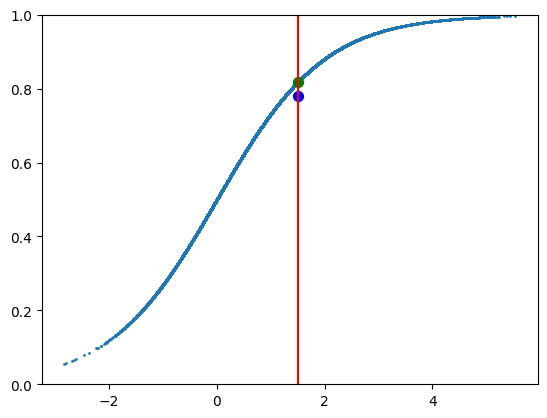

In [24]:

"""
Idea:

We have two features: X1 independant from X2, both with mean 0.
We have following logistic regression model:  p = sigma(X1 + X2)  ## =>  beta = [1, 1]

Now, for all possible values of x1 in some range, we either calculate:
* Sigma(E[X1 + X2 | x1])  ## => sigma(x1 + E[X2]) = sigma(x1)
* E[sigma(X1 + X2 | x1)]  ## => E[sigma(x1 + X2)] ≈ 1/k * SUM(sigma(x1 + x2')) for all x2' sampled from its distribution


"""

## 1. For a specific value of x1, calculate both E(sigma(x1 + x2)) and sigma(E(x1 + x2)):

n = 100000

mu = 1.5
var = np.random.normal(0,1,n)

logits = mu + np.array(var).reshape(-1,1)
probs = sigma(logits)

# mean of sigma(X)
print("E[sigma(X)]: ", np.mean(probs))

# sigma of mean(X)
print("Sigma(E[X]): ", sigma(mu))

plt.scatter(logits, probs, s=1)
plt.axvline(x=mu, color='r')
plt.scatter(mu, sigma(mu), color='g', s=50, marker='o')
plt.scatter(mu, np.mean(probs), color='b', s=50, marker='o')
plt.ylim(0,1)
plt.show()


In [30]:
## 2. For a range of x1 values, calculate both E(sigma(x1 + x2)) and sigma(E(x1 + x2)):

n = 100000
scale = 2

MUs = np.arange(-5,15,0.25)

results = pd.DataFrame(columns=["mu", "mean_probs", "sigma_mean"], index=MUs)

for mu in MUs:

    var = np.random.normal(0,scale,n)

    logits = mu + np.array(var).reshape(-1,1)
    probs = sigma(logits)

    mean_probs = np.mean(probs)

    sigma_mean = sigma(mu)

    results.loc[mu] = [mu, mean_probs, sigma_mean]

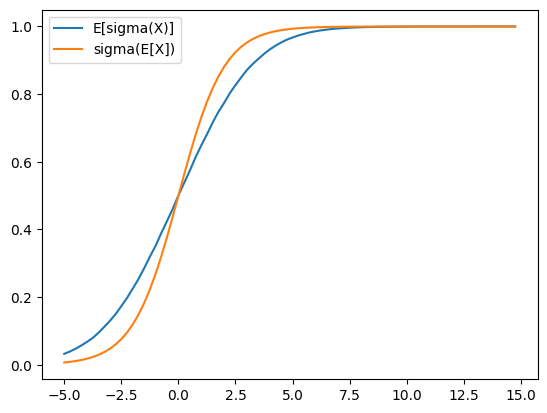

In [31]:
plt.plot(results["mu"], results["mean_probs"], label="E[sigma(X)]")
plt.plot(results["mu"], results["sigma_mean"], label="sigma(E[X])")
plt.legend()
plt.show()

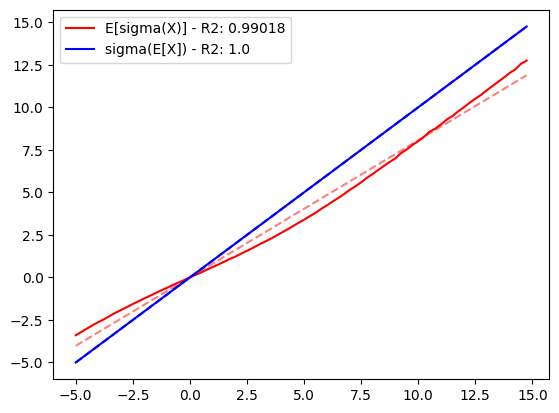

In [32]:
## 3. Transform the results to logits and calculate the R2 of the linear regression between mu and the transformed values:

results = results.astype(float)

results["logits_mean_probs"] = np.log(results["mean_probs"] / (1 - results["mean_probs"]))
results["logits_sigma_mean"] = np.log(results["sigma_mean"] / (1 - results["sigma_mean"]))

lr = LinearRegression()
lr.fit(results["mu"].values.reshape(-1,1), results["logits_mean_probs"])
r2_mean_probs = np.round(lr.score(results["mu"].values.reshape(-1,1), results["logits_mean_probs"]),5)
preds_probs = lr.predict(results["mu"].values.reshape(-1,1))

lr = LinearRegression()
lr.fit(results["mu"].values.reshape(-1,1), results["logits_sigma_mean"])
r2_sigma_mean = np.round(lr.score(results["mu"].values.reshape(-1,1), results["logits_sigma_mean"]),5)
preds_sigma = lr.predict(results["mu"].values.reshape(-1,1))

plt.plot(results["mu"], results["logits_mean_probs"], label=f"E[sigma(X)] - R2: {r2_mean_probs}", color="r")
plt.plot(results["mu"], preds_probs, color="r", linestyle="--", alpha=0.5)
plt.plot(results["mu"], results["logits_sigma_mean"], label=f"sigma(E[X]) - R2: {r2_sigma_mean}", color="b")
plt.plot(results["mu"], preds_sigma, linestyle="--", color="b")
plt.legend()
plt.show()


#### Skew distribution

E[sigma(X)]:  0.7600107533321373
Sigma(E[X]):  0.8175744761936437


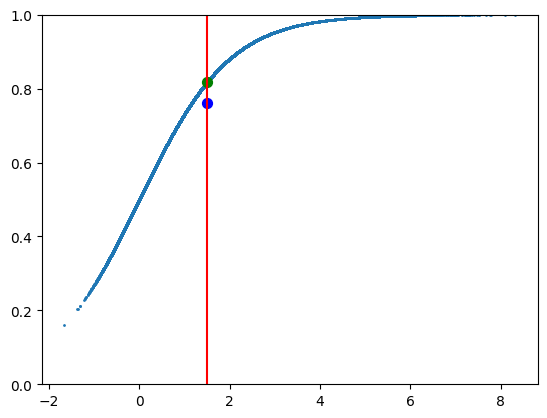

In [6]:

"""
Idea:

We have two features: X1 independant from X2, both with mean 0.
We have following logistic regression model:  Y = sigma(X1 + X2)  ## =>  beta = [1, 1]

Now, for all possible values of x1 in some range, we either calculate:
* Sigma(E[X1 + X2 | x1])  ## => sigma(x1 + E[X2]) = sigma(x1)
* E[sigma(X1 + X2 | x1)]  ## => E[sigma(x1 + X2)] ≈ 1/k * SUM(sigma(x1 + x2')) for all x2' sampled from its distribution


"""

from scipy import stats

## 1. For a specific value of x1, calculate both E(sigma(x1 + x2)) and sigma(E(x1 + x2)):

n = 100000

mu = 1.5
scale = 2
skew = 5
draws = stats.skewnorm.rvs(skew, size=n, loc=0, scale=scale)
var = draws - np.mean(draws)

logits = mu + np.array(var).reshape(-1,1)
probs = sigma(logits)

# mean of sigma(X)
print("E[sigma(X)]: ", np.mean(probs))

# sigma of mean(X)
print("Sigma(E[X]): ", sigma(mu))

plt.scatter(logits, probs, s=1)
plt.axvline(x=mu, color='r')
plt.scatter(mu, sigma(mu), color='g', s=50, marker='o')
plt.scatter(mu, np.mean(probs), color='b', s=50, marker='o')
plt.ylim(0,1)
plt.show()


In [7]:
## 2. For a range of x1 values, calculate both E(sigma(x1 + x2)) and sigma(E(x1 + x2)):

n = 100000
scale = 7
skew = 10

MUs = np.arange(-15,15,0.25)

results = pd.DataFrame(columns=["mu", "mean_probs", "sigma_mean"], index=MUs)

for mu in MUs:

    draws = stats.skewnorm.rvs(skew, size=n, loc=0, scale=scale)
    var = draws - np.mean(draws)

    logits = mu + np.array(var).reshape(-1,1)
    probs = sigma(logits)

    mean_probs = np.mean(probs)

    sigma_mean = sigma(mu)

    results.loc[mu] = [mu, mean_probs, sigma_mean]

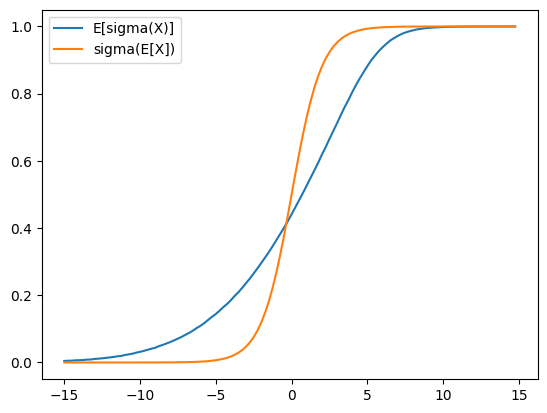

In [8]:
plt.plot(results["mu"], results["mean_probs"], label="E[sigma(X)]")
plt.plot(results["mu"], results["sigma_mean"], label="sigma(E[X])")
plt.legend()
plt.show()

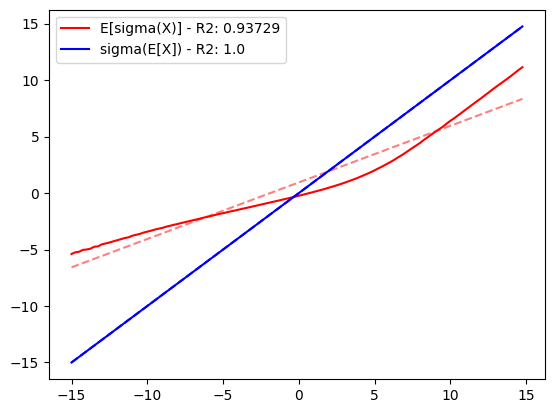

In [9]:
## 3. Transform the results to logits and calculate the R2 of the linear regression between mu and the transformed values:

results = results.astype(float)

results["logits_mean_probs"] = np.log(results["mean_probs"] / (1 - results["mean_probs"]))
results["logits_sigma_mean"] = np.log(results["sigma_mean"] / (1 - results["sigma_mean"]))

lr = LinearRegression()
lr.fit(results["mu"].values.reshape(-1,1), results["logits_mean_probs"])
r2_mean_probs = np.round(lr.score(results["mu"].values.reshape(-1,1), results["logits_mean_probs"]),5)
preds_probs = lr.predict(results["mu"].values.reshape(-1,1))

lr = LinearRegression()
lr.fit(results["mu"].values.reshape(-1,1), results["logits_sigma_mean"])
r2_sigma_mean = np.round(lr.score(results["mu"].values.reshape(-1,1), results["logits_sigma_mean"]),5)
preds_sigma = lr.predict(results["mu"].values.reshape(-1,1))

plt.plot(results["mu"], results["logits_mean_probs"], label=f"E[sigma(X)] - R2: {r2_mean_probs}", color="r")
plt.plot(results["mu"], preds_probs, color="r", linestyle="--", alpha=0.5)
plt.plot(results["mu"], results["logits_sigma_mean"], label=f"sigma(E[X]) - R2: {r2_sigma_mean}", color="b")
plt.plot(results["mu"], preds_sigma, linestyle="--", color="b")
plt.legend()
plt.show()


#### Now real data

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from utils import *
from scipy import stats

In [11]:
d = 2
n = 50000

def toep(d, corr_rate):
    a = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            a[i, j] = corr_rate ** abs(i - j)
    return a

def generate_X(n, d, skew=0, cov_vector=None):

    if d != 2:
        raise ValueError("Only d=2 is supported")

    if cov_vector is None:
        cov_vector = np.ones(d)

    X = np.zeros((n, d))
    X[:,0] = np.random.normal(0, cov_vector[0], n)
    X[:, 1] = stats.skewnorm.rvs(skew, size=n, loc=0, scale=cov_vector[1])
    X[:,1] = X[:,1] - np.mean(X[:,1])


    return X



cov_vector = [3,15]
skew = 15

X_full = generate_X(n=n, d=d, skew=skew, cov_vector=cov_vector)

M = generate_mask(n=n, d=d, prc=0.30)
X = X_full.copy()
X[M == 1] = np.nan

beta = [1,1]

y_logits_true = np.dot(X_full, beta)
y_probs_true = 1 / (1 + np.exp(-y_logits_true))
y = np.random.binomial(1, y_probs_true)


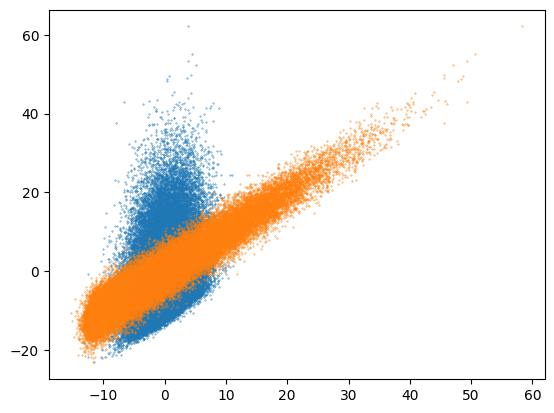

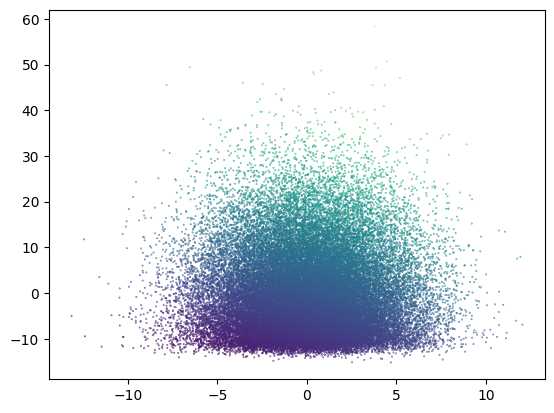

In [12]:
plt.scatter(X_full[:,0], y_logits_true, s=0.1)
plt.scatter(X_full[:,1], y_logits_true, s=0.1)
plt.show()
plt.scatter(X_full[:,0], X_full[:,1], c=y_logits_true, s=0.1);

In [13]:
def get_y_prob_bayes_independent(Xobs, mask, cov_vector, skew_mis, true_beta, n_mc=1000, intercept=0):

    M = np.isnan(Xobs)
    
    # Preallocate result array
    prob_y_all = np.zeros((Xobs.shape[0]))

    # Pattern 01:
    idx_01 = np.where(np.all(M == [0,1], axis=1))[0]
    prob_y_all[idx_01] = get_y_prob_bayes_pattern_01(Xobs[idx_01, 0], cov_vector[1], skew_mis, true_beta, n_mc=n_mc, intercept=intercept)

    # pattern 10:
    idx_10 = np.where(np.all(M == [1,0], axis=1))[0]
    prob_y_all[idx_10] = get_y_prob_bayes_pattern_10(Xobs[idx_10, 1], cov_vector[0], 0, true_beta, n_mc=n_mc, intercept=intercept)

    # pattern 11:
    idx_11 = np.where(np.all(M == [1,1], axis=1))[0]
    prob_y_all[idx_11] = get_y_prob_bayes_pattern_11(Xobs[idx_11], cov_vector, skew_mis, true_beta, n_mc=n_mc, intercept=intercept)

    idx_00 = np.where(np.all(M == [0,0], axis=1))[0]
    if len(idx_00) > 0:
        logits = np.dot(Xobs[idx_00], true_beta) + intercept
        prob_y_all[idx_00] = 1 / (1 + np.exp(-logits))

    return prob_y_all

def get_y_prob_bayes_pattern_01(Xobs, scale_mis, skew_mis, true_beta, n_mc=1000, intercept=0):

    # Generate n_mc samples from Distribution of Missing Values
    X_MISS = stats.skewnorm.rvs(skew_mis, size=(n_mc, 1), loc=0, scale=scale_mis)
    X_MISS = X_MISS - np.mean(X_MISS, axis=0)

    logits_1 = Xobs * true_beta[0]
    logits_2 = X_MISS * true_beta[1]

    logits = logits_1 + logits_2 + intercept

    probs = 1 / (1 + np.exp(-logits))

    probs_bayes = np.mean(probs, axis=0)

    return probs_bayes

def get_y_prob_bayes_pattern_10(Xobs, scale_mis, skew_mis, true_beta, n_mc=1000, intercept=0):

    # Generate n_mc samples from Distribution of Missing Values
    X_MISS = np.random.normal(0, scale_mis, size=(n_mc, 1))

    logits_1 = X_MISS * true_beta[0]
    logits_2 = Xobs * true_beta[1]

    logits = logits_1 + logits_2 + intercept

    probs = 1 / (1 + np.exp(-logits))

    probs_bayes = np.mean(probs, axis=0)

    return probs_bayes

def get_y_prob_bayes_pattern_11(Xobs, cov_vector, skew_mis, true_beta, n_mc=1000, intercept=0):

    X_gen = generate_X(n=n_mc, d=2, skew=skew_mis, cov_vector=cov_vector)
    y_logits = np.dot(X_gen, true_beta) + intercept
    y_probs = 1 / (1 + np.exp(-y_logits))

    probs_bayes = np.mean(y_probs)

    # repeat for all MC samples
    probs_bayes = np.repeat(probs_bayes, Xobs.shape[0])

    return probs_bayes


In [14]:

y_bayes = get_y_prob_bayes_independent(X, M, cov_vector, skew_mis=10, true_beta=beta, n_mc=500, intercept=0)
y_bayes_logit = np.log(y_bayes / (1 - y_bayes))


C:\Users\Chris\AppData\Local\Temp\ipykernel_4908\3011447406.py:2: RuntimeWarning: divide by zero encountered in divide
  y_bayes_logit = np.log(y_bayes / (1 - y_bayes))


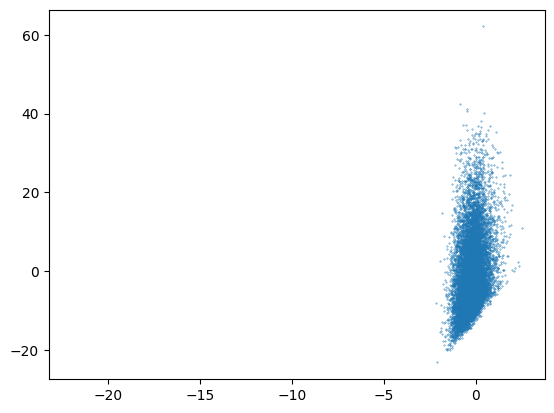

In [15]:
idx = get_index_pattern([0,1], M)

plt.scatter(y_bayes_logit[idx], y_logits_true[idx], s=0.1)
plt.plot([np.min(y_bayes_logit), np.max(y_bayes_logit)], [np.min(y_bayes_logit), np.max(y_bayes_logit)], color='r')


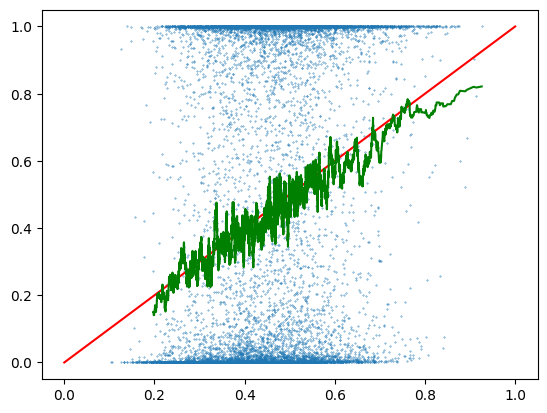

In [16]:
plt.scatter(y_bayes[idx], y_probs_true[idx], s=0.1)
plt.plot([np.min(y_bayes), np.max(y_bayes)], [np.min(y_bayes), np.max(y_bayes)], color='r')
ord = np.argsort(y_bayes[idx])
mean_true = pd.Series(y_probs_true[idx][ord]).rolling(window=100).mean()
# mean_true = pd.Series(y_logits_true[idx][ord]).rolling(window=1000).mean()
plt.plot(y_bayes[idx][ord], mean_true, color='g')
plt.show()


In [17]:
n_train = 2000
n_test = 5000
id_test = len(X) - n_test

# 1. Train PbP model:

from methods import RegLogPatByPat

model = RegLogPatByPat(name="PbP")
model.fit(X[:n_train], M[:n_train] ,y[:n_train])

c:\Users\Chris\Anaconda3\envs\logistic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
y_preds = model.predict_probs(X[id_test:], M[id_test:])

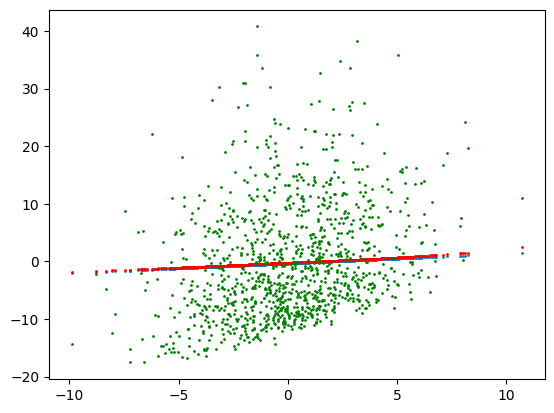

In [19]:
y_preds_logit = np.log(y_preds / (1 - y_preds))

idx_test = get_index_pattern([0,1], M[id_test:])

plt.scatter(X_full[id_test:, 0][idx_test], y_preds_logit[idx_test], s=1)
plt.scatter(X_full[id_test:, 0][idx_test], y_bayes_logit[id_test:][idx_test], color='r', s=1)
plt.scatter(X_full[id_test:, 0][idx_test], y_logits_true[id_test:][idx_test], color='g', s=1)
plt.show()

In [20]:
M_test = M[id_test:]
idx = get_index_pattern([0,1], M_test)

mse_bayes = np.mean((y_bayes[id_test:][idx] - y_probs_true[id_test:][idx])**2)
mse_preds = np.mean((y_preds[idx] - y_probs_true[id_test:][idx])**2)

mae_bayes = np.mean(np.abs(y_bayes[id_test:][idx] - y_probs_true[id_test:][idx]))
mae_preds = np.mean(np.abs(y_preds[idx] - y_probs_true[id_test:][idx]))

print(f"MSE Bayes: {mse_bayes}")
print(f"MSE Preds: {mse_preds}")
print(f"MAE Bayes: {mae_bayes}")
print(f"MAE Preds: {mae_preds}")

MSE Bayes: 0.19952269184541202
MSE Preds: 0.1989100648977834
MAE Bayes: 0.4216238732668132
MAE Preds: 0.4182434316413497


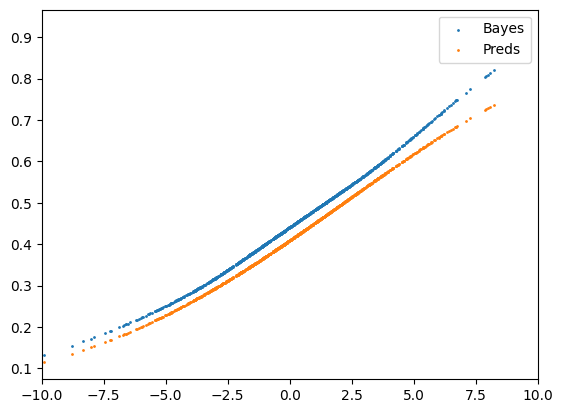

In [21]:
from_ = -10
to_ = 10

plt.scatter(X[id_test:, 0][idx_test], y_bayes[id_test:][idx_test], s=1, label="Bayes")
plt.scatter(X[id_test:, 0][idx_test], y_preds[idx_test], s=1, label="Preds")

plt.xlim(from_, to_)

plt.legend()

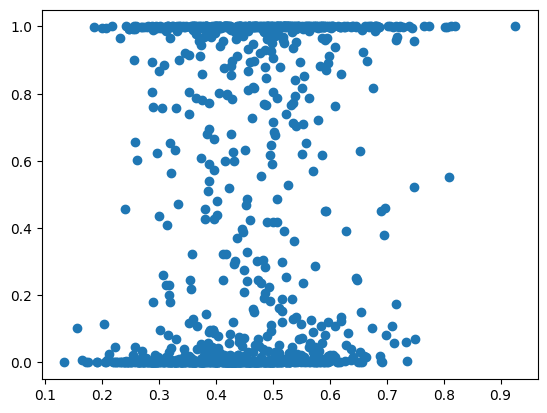

In [22]:
plt.scatter(y_bayes[id_test:][idx_test], y_probs_true[id_test:][idx_test])